<a href="https://colab.research.google.com/github/artgillespie/stable-diffusion-research/blob/main/notebooks/MLFS_StableDiffusion_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning From Scratch : Stable Diffusion Playground (Day 1)

Binxu Wang

This is the notebook of MLFS day 1. It has many sections with loose order between them. You can
* Play with generating art from prompt.
* See the effect of the parameters for generating process.
* Visualizing the diffusion process and latents
* Looking under the hood of the sampling function.
* Inspect the internal network architecture of the components of Stable Diffusion.

In [1]:
!pip install diffusers transformers tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.5 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.21.2-py3-none-any.whl size=1489250 sha256=e8915c3d6e816f7c7bd7837a9af55132247e6c6e3d9f998551aaeb881a4600b4
  Stored in directory: /root/.cache/pip/wheels/2e/09/32/11c9e42c397d3f3494226b28ba68c4ad4718a68a65dba14ea6
Successfully built diffusers


Note you need to login to use the pre-trained weights! You should register an account at Huggingface, then use one `Access Tokens` to login in the following block.

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Make sure you have a runtime with GPU!

In [4]:
import torch
assert torch.cuda.is_available()
!nvidia-smi

Thu Sep 21 21:56:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading Stable Diffusion

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autocast
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

def plt_show_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
assert torch.cuda.is_available()
!nvidia-smi

Tue Nov  1 09:27:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Here `fp16` checkpoint is loaded just to save memory and compute time. if you have a great gpu, you can remove the line `revision="fp16", torch_dtype=torch.float16`.

In [8]:
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    use_auth_token=True,
    revision="fp16", torch_dtype=torch.float16
).to("cuda")
# Disable the safety checkers
# def dummy_checker(images, **kwargs): return images, False
# pipe.safety_checker = dummy_checker

unet/diffusion_pytorch_model.safetensors not found
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


## Generative Playground

  0%|          | 0/50 [00:00<?, ?it/s]

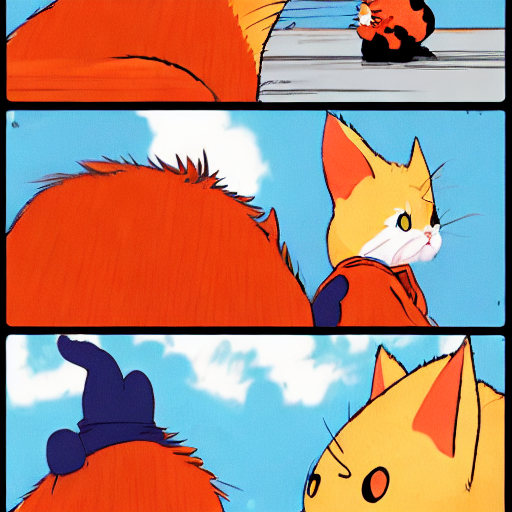

In [15]:
prompt = "a mean orange cat with a huge attitude bullying a sweet dog in Miyazaki style from Kiki's Delivery Service."
image = pipe(prompt).images[0]

image.save(f"link.png")
image

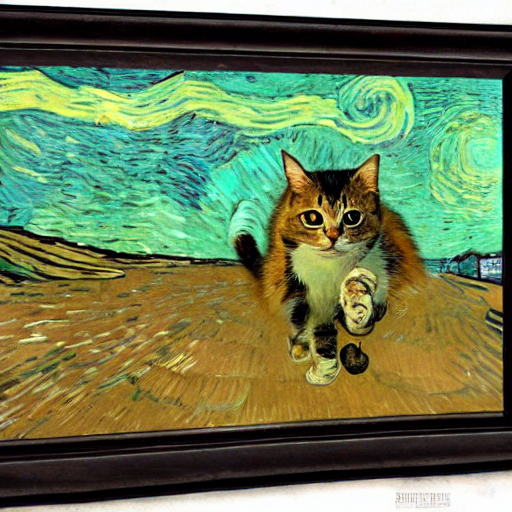

In [ ]:
image #  "a lovely cat running in the desert in Van Gogh style, trending art."

### Fixing the random seed

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


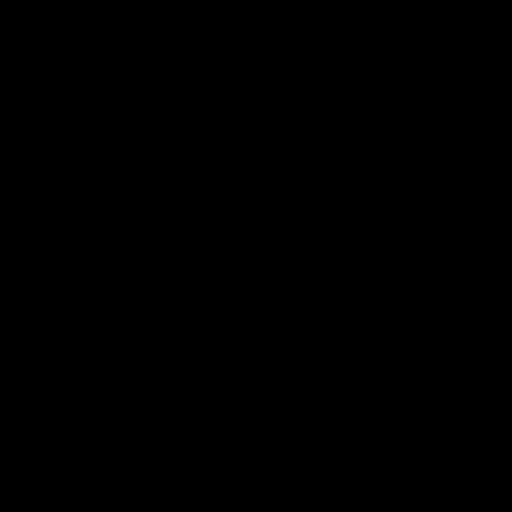

In [19]:
generator = torch.Generator("cuda").manual_seed(1024)

prompt = "an orange kitten sleeping."
image = pipe(prompt, generator=generator).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can do either save it such as:
image.save(f"kitten.png")
image

### Changing (Denoising) Diffusion steps

  0%|          | 0/25 [00:00<?, ?it/s]

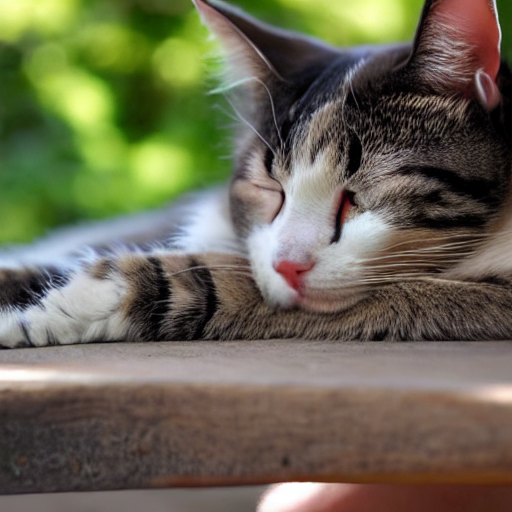

In [20]:
prompt = "a sleeping cat enjoying the sunshine."
image = pipe(prompt, num_inference_steps=25).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can do either save it such as:
image.save(f"lovely_cat_sun.png")
image

### Adding Negative prompt

Adding negative prompt can control what you do not want.

  0%|          | 0/51 [00:00<?, ?it/s]

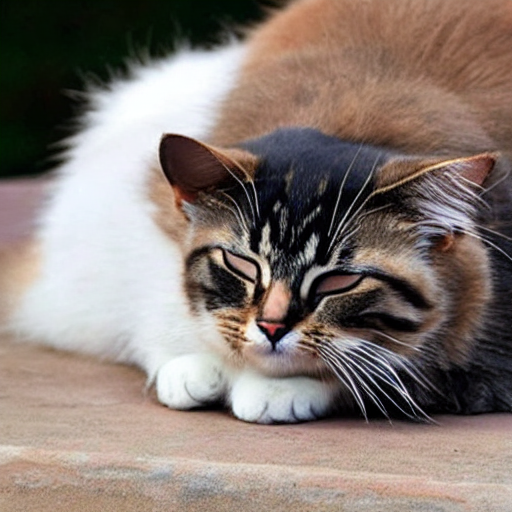

In [ ]:
prompt = "a sleeping cat enjoying the sunshine."
image = pipe(prompt, generator=generator,
               negative_prompt="tree and leaves").images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can do either save it such as:
image.save(f"lovely_cat_sun_no_trees.png")
image

## Visualizing the Diffusion in Action

First import some utils for showing videos in colab.

In [21]:
# https://colab.research.google.com/github/google/mediapy/blob/main/mediapy_examples.ipynb#scrollTo=u0kuKXep2pfr
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import itertools
import math
import mediapy as media

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.5 MB/s eta 0:00:00


In [22]:
!mkdir diffprocess

In [23]:
image_reservoir = []
latents_reservoir = []


@torch.no_grad()
def plot_show_callback(i, t, latents):
    latents_reservoir.append(latents.detach().cpu())
    image = pipe.vae.decode(1 / 0.18215 * latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()[0]
    # plt_show_image(image)
    plt.imsave(f"diffprocess/sample_{i:02d}.png", image)
    image_reservoir.append(image)


@torch.no_grad()
def save_latents(i, t, latents):
    latents_reservoir.append(latents.detach().cpu())

These callback functions will save the image in the process into a list `image_reservoir` and latents into `latents_reservoir`.

  0%|          | 0/50 [00:00<?, ?it/s]

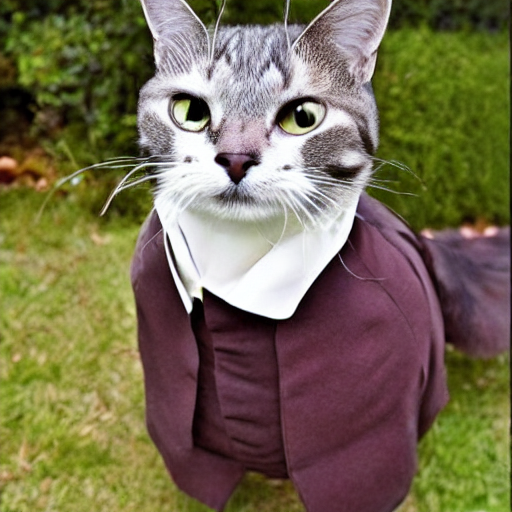

In [24]:
prompt = "a handsome cat dressed like Lincoln, trending art."
with torch.no_grad():
  image = pipe(prompt, callback=plot_show_callback).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can do either save it such as:
image.save(f"lovely_cat_lincoln.png")
image

### Visualizing Image sequence

In [25]:
# video1 = media.moving_circle((65, 65), num_images=10)
media.show_video(image_reservoir, fps=5)

### Visualizing latents

 What about the latents? How do they change in the diffusion process?

In [26]:
latents_reservoir[0].shape

torch.Size([1, 4, 64, 64])

Since we have 4 channel in the latent tensor, we can choose to visualize any 3 of them as RGB. You can put any number in 0,1,2,3 in the `Chan2RGB` list. see what it visualize

In [27]:
Chan2RGB = [0,1,2]
latents_np_seq = [tsr[0,Chan2RGB].permute(1,2,0).numpy() for tsr in latents_reservoir]

In [28]:
media.show_video(latents_np_seq, fps=5)

## Write a simple text2img sampling function

Here I provide a simplified version of the sampling function! See what happened under the hood when you run `pipe(prompt)`

Feel free to print out tensors and record their shape within this function!

  0%|          | 0/51 [00:00<?, ?it/s]

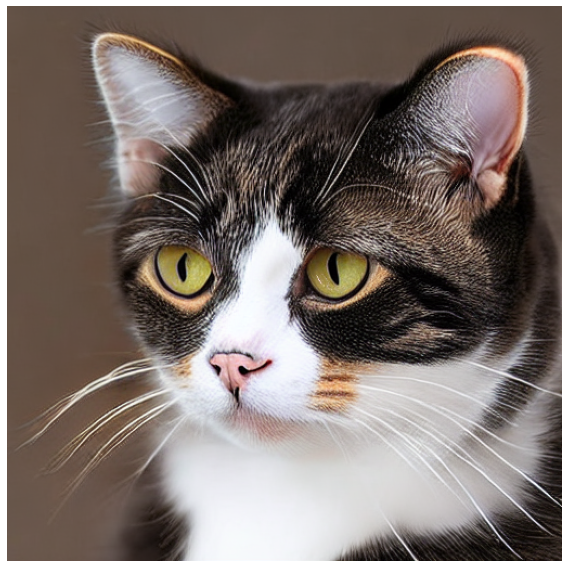

In [ ]:
@torch.no_grad()
def generate_simplified(
    prompt = ["a lovely cat"],
    negative_prompt = [""],
    num_inference_steps = 50,
    guidance_scale = 7.5):
    # do_classifier_free_guidance
    batch_size = 1
    height, width = 512, 512
    generator = None
    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.

    # get prompt text embeddings
    text_inputs = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids
    text_embeddings = pipe.text_encoder(text_input_ids.to(pipe.device))[0]
    bs_embed, seq_len, _ = text_embeddings.shape

    # get negative prompts  text embedding
    max_length = text_input_ids.shape[-1]
    uncond_input = pipe.tokenizer(
        negative_prompt,
        padding="max_length",
        max_length=max_length,
        truncation=True,
        return_tensors="pt",
    )
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(pipe.device))[0]

    # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
    seq_len = uncond_embeddings.shape[1]
    uncond_embeddings = uncond_embeddings.repeat(batch_size, 1, 1)
    uncond_embeddings = uncond_embeddings.view(batch_size, seq_len, -1)

    # For classifier free guidance, we need to do two forward passes.
    # Here we concatenate the unconditional and text embeddings into a single batch
    # to avoid doing two forward passes
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # get the initial random noise unless the user supplied it
    # Unlike in other pipelines, latents need to be generated in the target device
    # for 1-to-1 results reproducibility with the CompVis implementation.
    # However this currently doesn't work in `mps`.
    latents_shape = (batch_size, pipe.unet.in_channels, height // 8, width // 8)
    latents_dtype = text_embeddings.dtype
    latents = torch.randn(latents_shape, generator=generator, device=pipe.device, dtype=latents_dtype)

    # set timesteps
    pipe.scheduler.set_timesteps(num_inference_steps)
    # Some schedulers like PNDM have timesteps as arrays
    # It's more optimized to move all timesteps to correct device beforehand
    timesteps_tensor = pipe.scheduler.timesteps.to(pipe.device)
    # scale the initial noise by the standard deviation required by the scheduler
    latents = latents * pipe.scheduler.init_noise_sigma

    # Main diffusion process
    for i, t in enumerate(pipe.progress_bar(timesteps_tensor)):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(noise_pred, t, latents, ).prev_sample

    latents = 1 / 0.18215 * latents
    image = pipe.vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()
    return image

image = generate_simplified(
    prompt = ["a lovely cat"],
    negative_prompt = ["Sunshine"],)
plt_show_image(image[0])

  0%|          | 0/51 [00:00<?, ?it/s]

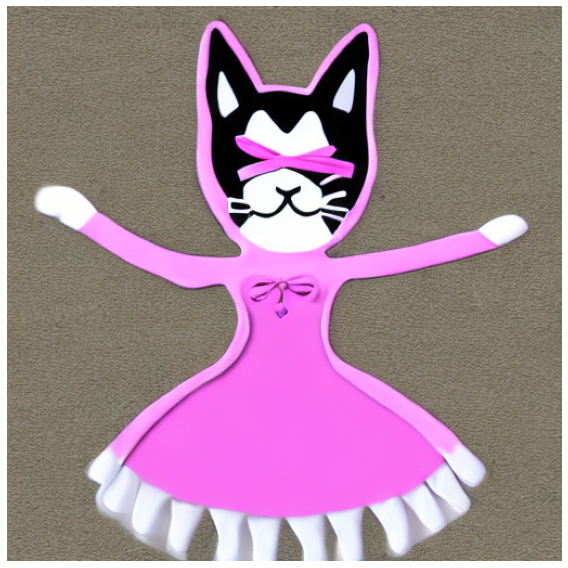

In [ ]:
image = generate_simplified(
    prompt = ["a cat dressed like a ballerina"],
    negative_prompt = [""],)
plt_show_image(image[0])

## Image to Image Translation Playground

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline

In [ ]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    revision="fp16",  torch_dtype=torch.float16,
    use_auth_token=True
)
pipe = pipe.to(device)

In [ ]:
import requests
from io import BytesIO
from PIL import Image

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = init_img.resize((768, 512))
init_img

In [ ]:
prompt = "A fantasy landscape, trending on artstation"
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img,
                 strength=0.75, guidance_scale=7.5,
                 generator=generator).images[0]

image

## Write a simple img2img sampling function

In [ ]:
@torch.no_grad()
def generate_img2img_simplified():
    prompt = ["A fantasy landscape, trending on artstation"]
    negative_prompt = [""]
    strength = 0.5 # strength of the image conditioning
    batch_size = 1

    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    # set timesteps
    pipe.scheduler.set_timesteps(num_inference_steps)

    # get prompt text embeddings
    text_inputs = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids
    text_embeddings = pipe.text_encoder(text_input_ids.to(pipe.device))[0]

    # get unconditional embeddings for classifier free guidance
    uncond_tokens = negative_prompt
    max_length = text_input_ids.shape[-1]
    uncond_input = pipe.tokenizer(
        uncond_tokens,
        padding="max_length",
        max_length=max_length,
        truncation=True,
        return_tensors="pt",
    )
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(pipe.device))[0]

    # For classifier free guidance, we need to do two forward passes.
    # Here we concatenate the unconditional and text embeddings into a single batch
    # to avoid doing two forward passes
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # encode the init image into latents and scale the latents
    latents_dtype = text_embeddings.dtype
    if isinstance(init_image, PIL.Image.Image):
        init_image = preprocess(init_image)
    init_image = init_image.to(device=pipe.device, dtype=latents_dtype)
    init_latent_dist = pipe.vae.encode(init_image).latent_dist
    init_latents = init_latent_dist.sample(generator=generator)
    init_latents = 0.18215 * init_latents

    # get the original timestep using init_timestep
    offset = pipe.scheduler.config.get("steps_offset", 0)
    init_timestep = int(num_inference_steps * strength) + offset
    init_timestep = min(init_timestep, num_inference_steps)

    timesteps = pipe.scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps] * batch_size, device=pipe.device)

    # add noise to latents using the timesteps
    noise = torch.randn(init_latents.shape, generator=generator, device=pipe.device, dtype=latents_dtype)
    init_latents = pipe.scheduler.add_noise(init_latents, noise, timesteps)

    latents = init_latents

    t_start = max(num_inference_steps - init_timestep + offset, 0)
    # Some schedulers like PNDM have timesteps as arrays
    # It's more optimized to move all timesteps to correct device beforehand
    timesteps = pipe.scheduler.timesteps[t_start:].to(pipe.device)

    for i, t in enumerate(pipe.progress_bar(timesteps)):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

    latents = 1 / 0.18215 * latents
    image = pipe.vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    return image

-----------------------

## The Internal Structure of Model

First I'll define a function to help you see the internal structure of diffusion model. Use the `deepest` argument to choose how much details you want to see.

In [ ]:
def recursive_print(module, prefix="", depth=0, deepest=3):
    """Simulating print(module) for torch.nn.Modules
        but with depth control. Print to the `deepest` level. `deepest=0` means no print
    """
    if depth == 0:
        print(f"[{type(module).__name__}]")
    if depth >= deepest:
        return
    for name, child in module.named_children():
        if len([*child.named_children()]) == 0:
            print(f"{prefix}({name}): {child}")
        else:
            if isinstance(child, nn.ModuleList):
                print(f"{prefix}({name}): {type(child).__name__} len={len(child)}")
            else:
                print(f"{prefix}({name}): {type(child).__name__}")
        recursive_print(child, prefix + "  ", depth + 1, deepest)


### Text encoding model

Now let's look at the text encoding model.

In [ ]:
# The text model or our CLIP model
recursive_print(pipe.text_encoder, deepest=3)

[CLIPTextModel]
(text_model): CLIPTextTransformer
  (embeddings): CLIPTextEmbeddings
    (token_embedding): Embedding(49408, 768)
    (position_embedding): Embedding(77, 768)
  (encoder): CLIPEncoder
    (layers): ModuleList len=12
  (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)


Let's zoom in onto the `encoder`, you can see it's basically a series of Transformer blocks.

In [ ]:
# the internal structure of a text encoder is basically a series of Transformer blocks
recursive_print(pipe.text_encoder.text_model.encoder, deepest=3)

[CLIPEncoder]
(layers): ModuleList len=12
  (0): CLIPEncoderLayer
    (self_attn): CLIPAttention
    (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): CLIPMLP
    (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (1): CLIPEncoderLayer
    (self_attn): CLIPAttention
    (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): CLIPMLP
    (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (2): CLIPEncoderLayer
    (self_attn): CLIPAttention
    (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): CLIPMLP
    (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (3): CLIPEncoderLayer
    (self_attn): CLIPAttention
    (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): CLIPMLP
    (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): CLIPEncoderLayer
    (self_attn): CLIPAttention
    (layer_norm1): Laye

What's inside one of these blocks? Can you guess from what you've learned about attention?

In [ ]:
recursive_print(pipe.text_encoder.text_model.encoder.layers[0], deepest=3)

[CLIPEncoderLayer]
(self_attn): CLIPAttention
  (k_proj): Linear(in_features=768, out_features=768, bias=True)
  (v_proj): Linear(in_features=768, out_features=768, bias=True)
  (q_proj): Linear(in_features=768, out_features=768, bias=True)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
(layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
(mlp): CLIPMLP
  (activation_fn): QuickGELUActivation()
  (fc1): Linear(in_features=768, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=768, bias=True)
(layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)


### UNet model

Let's dive into the most complicated part of the Stable Diffusion model, the UNet.

In the following block you can see the grand design of UNet, `down_blocks` `up_blocks` `mid_block`.

In [ ]:
recursive_print(pipe.unet, deepest=2)

[UNet2DConditionModel]
(conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(time_proj): Timesteps()
(time_embedding): TimestepEmbedding
  (linear_1): Linear(in_features=320, out_features=1280, bias=True)
  (act): SiLU()
  (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
(down_blocks): ModuleList len=4
  (0): CrossAttnDownBlock2D
  (1): CrossAttnDownBlock2D
  (2): CrossAttnDownBlock2D
  (3): DownBlock2D
(up_blocks): ModuleList len=4
  (0): UpBlock2D
  (1): CrossAttnUpBlock2D
  (2): CrossAttnUpBlock2D
  (3): CrossAttnUpBlock2D
(mid_block): UNetMidBlock2DCrossAttn
  (attentions): ModuleList len=1
  (resnets): ModuleList len=2
(conv_norm_out): GroupNorm(32, 320, eps=1e-05, affine=True)
(conv_act): SiLU()
(conv_out): Conv2d(320, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


So what's inside one `CrossAttnDownBlock2D`, basically it's the double sandwich of `attentions` and `resnets`. You can see similar things for the `CrossAttnUpBlock2D`.


In [ ]:
recursive_print(pipe.unet.down_blocks[0], deepest=2)

[CrossAttnDownBlock2D]
(attentions): ModuleList len=2
  (0): SpatialTransformer
  (1): SpatialTransformer
(resnets): ModuleList len=2
  (0): ResnetBlock2D
  (1): ResnetBlock2D
(downsamplers): ModuleList len=1
  (0): Downsample2D


In [ ]:
recursive_print(pipe.unet.up_blocks[2], deepest=2)

[CrossAttnUpBlock2D]
(attentions): ModuleList len=3
  (0): SpatialTransformer
  (1): SpatialTransformer
  (2): SpatialTransformer
(resnets): ModuleList len=3
  (0): ResnetBlock2D
  (1): ResnetBlock2D
  (2): ResnetBlock2D
(upsamplers): ModuleList len=1
  (0): Upsample2D


Thus I think I've convinced you that understanding the `SpatialTransformer` and the `ResnetBlock2D`, then you basically understand the building block of the network.

#### Spatial Transformer

In the lecture, you have seen the spatial transformer is basically a composition of
* self-attention,
* cross-attention
* a feed-forward network.

You can see this structure in one of the `SpatialTransformer` layer.

In [ ]:
recursive_print(pipe.unet.down_blocks[0].attentions[0], deepest=3)

[SpatialTransformer]
(norm): GroupNorm(32, 320, eps=1e-06, affine=True)
(proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
(transformer_blocks): ModuleList len=1
  (0): BasicTransformerBlock
    (attn1): CrossAttention
    (ff): FeedForward
    (attn2): CrossAttention
    (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
(proj_out): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))


Next, let's focus on the two `attn1`,`attn2` layers.

**Quiz time**: Can you guess what will be different between them? Specifically, which weight tensor will have a different shape? Which of these?
* Q
* K
* V

In [ ]:
# the img2img cross attention
recursive_print(pipe.unet.down_blocks[0].attentions[0].transformer_blocks[0].attn1, deepest=3)

In [ ]:
# the img2text cross attention
recursive_print(pipe.unet.down_blocks[0].attentions[0].transformer_blocks[0].attn2, deepest=3)

Finally, we take a look at the feed forward network.

Here it used a special kind of activation function `GEGLU` where the output of `proj` is cut in half, one half controling a sigmoid gate, the other half create the activation. But most of the time simper activation are used like `GeLU` `SiLU`.

In [ ]:
recursive_print(pipe.unet.down_blocks[0].attentions[0].transformer_blocks[0].ff, deepest=3)

[FeedForward]
(net): Sequential
  (0): GEGLU
    (proj): Linear(in_features=320, out_features=2560, bias=True)
  (1): Dropout(p=0.0, inplace=False)
  (2): Linear(in_features=1280, out_features=320, bias=True)


#### ResnetBlock2D

ResNet Block is the simplest part of the Unet! Basically a CNN like ResNet.   

In [ ]:
recursive_print(pipe.unet.down_blocks[0].resnets[0], deepest=3)

[ResnetBlock2D]
(norm1): GroupNorm(32, 320, eps=1e-05, affine=True)
(conv1): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(time_emb_proj): Linear(in_features=1280, out_features=320, bias=True)
(norm2): GroupNorm(32, 320, eps=1e-05, affine=True)
(dropout): Dropout(p=0.0, inplace=False)
(conv2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(nonlinearity): SiLU()


Notice the `time_emb_proj` this is the linear projection that output the time modulating signal for each channel.

#### Time Embedding

The function that creates the `sin` `cos` Fourier basis reads like this. (adapting the original code)

In [ ]:
import math
def time_proj(time_steps, max_period: int = 10000, time_emb_dim=320):
    if time_steps.ndim == 0:
        time_steps = time_steps.unsqueeze(0)
    half = time_emb_dim // 2
    frequencies = torch.exp(- math.log(max_period)
                            * torch.arange(start=0, end=half, dtype=torch.float32) / half
                            ).to(device=time_steps.device)
    angles = time_steps[:, None].float() * frequencies[None, :]
    return torch.cat([torch.cos(angles), torch.sin(angles)], dim=-1)

These outputs are sent to `time_embedding` network which is also really simple, basically a 2 layer MLP, expanding its dimensionality.

In [ ]:
recursive_print(pipe.unet.time_embedding)

[TimestepEmbedding]
(linear_1): Linear(in_features=320, out_features=1280, bias=True)
(act): SiLU()
(linear_2): Linear(in_features=1280, out_features=1280, bias=True)


### Autoencoder model

The Autoencoder is basically a ResNet based CNN.

In [ ]:
# The autoencoderKL or VAE
recursive_print(pipe.vae, deepest=3)

[AutoencoderKL]
(encoder): Encoder
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_blocks): ModuleList len=4
    (0): DownEncoderBlock2D
    (1): DownEncoderBlock2D
    (2): DownEncoderBlock2D
    (3): DownEncoderBlock2D
  (mid_block): UNetMidBlock2D
    (attentions): ModuleList len=1
    (resnets): ModuleList len=2
  (conv_norm_out): GroupNorm(32, 512, eps=1e-06, affine=True)
  (conv_act): SiLU()
  (conv_out): Conv2d(512, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(decoder): Decoder
  (conv_in): Conv2d(4, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up_blocks): ModuleList len=4
    (0): UpDecoderBlock2D
    (1): UpDecoderBlock2D
    (2): UpDecoderBlock2D
    (3): UpDecoderBlock2D
  (mid_block): UNetMidBlock2D
    (attentions): ModuleList len=1
    (resnets): ModuleList len=2
  (conv_norm_out): GroupNorm(32, 128, eps=1e-06, affine=True)
  (conv_act): SiLU()
  (conv_out): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), pa

If you look at the VAE `encoder`, you can find it's very similar to the encoder side of the `UNet`, but without any `SpatialTransformer`.

It only has `ResnetBlock2D` and downsamplers. It's reasonable that the VAE is **not modulated by word or time**, so it doesn't need cross attention.  

In [ ]:
recursive_print(pipe.vae.encoder.down_blocks, deepest=3)

[ModuleList]
(0): DownEncoderBlock2D
  (resnets): ModuleList len=2
    (0): ResnetBlock2D
    (1): ResnetBlock2D
  (downsamplers): ModuleList len=1
    (0): Downsample2D
(1): DownEncoderBlock2D
  (resnets): ModuleList len=2
    (0): ResnetBlock2D
    (1): ResnetBlock2D
  (downsamplers): ModuleList len=1
    (0): Downsample2D
(2): DownEncoderBlock2D
  (resnets): ModuleList len=2
    (0): ResnetBlock2D
    (1): ResnetBlock2D
  (downsamplers): ModuleList len=1
    (0): Downsample2D
(3): DownEncoderBlock2D
  (resnets): ModuleList len=2
    (0): ResnetBlock2D
    (1): ResnetBlock2D


So based on this knowledge, can you guess what will be different in the `ResnetBlock2D` here from the `ResnetBlock2D` in the Unet? What feature will be missing?

In [ ]:
recursive_print(pipe.vae.encoder.down_blocks[0].resnets[0], deepest=3)

[ResnetBlock2D]
(norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
(conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
(dropout): Dropout(p=0.0, inplace=False)
(conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(nonlinearity): SiLU()
